# Creates various benchmarks/baseline measures for GDP growth  / change

### Phase 1: Create Baselines
In this script, we create baseline forecasts for GDP change metrics of all countries for the year 2022 in 3 different ways:
1. Using T-1 prediction (repeat 2021 value) for 2022
2. Using expert prediction: by taking as given values from human experts (eg. IMF and World Bank)
3. Using a simple average of the last 10 years
4. Using an xgboost model trained on data from 2001 to 2020 to predict 2021

### Phase 2: Create error metrics
Compare how the LLM forecast compares to these 3 metrics

### Phase 3: Visualize results
Compare performance in tables, plots

## Setup

In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [205]:
from sklearn.linear_model import LinearRegression

In [206]:
from datetime import datetime

now = datetime.now() # current date and time
now_folder = now.strftime("%Y%m%d_%H%M")
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("results saved to:",now_folder)

results saved to: 20231205_1941


In [207]:
!mkdir $now_folder

### Parameters

In [208]:
PREDICTION_HORIZON = 1

In [209]:
finetuned_results_df = pd.read_csv('test_cleaned_gdp_growth_finetuned_predictions_' + str(PREDICTION_HORIZON) + 'yr.csv')
cleaned_gdp_growth_countries = pd.read_csv('cleaned_gdp_growth_df.csv')
rounded_gdp_growth_df = pd.read_csv('rounded_cleaned_gdp_growth_df.csv')
zero_shot_results_df = pd.read_csv('test_cleaned_gdp_growth_zero_shot_predictions_1yr_gpt-3.5-turbo-1106.csv')

In [210]:
base_zero_shot_results_df = pd.read_csv('test_cleaned_gdp_growth_zero_shot_predictions_1yr_base3.5.csv')

In [211]:
PREDICTION_YEAR = '2022'

In [212]:
# drop any rows with nan values
print(zero_shot_results_df.shape[0])
print(base_zero_shot_results_df.shape[0])
print(finetuned_results_df.shape[0])
print(cleaned_gdp_growth_countries.shape[0])
print(rounded_gdp_growth_df.shape[0])

182
182
182
196
182


#### Quick scan the data

In [213]:
zero_shot_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,4.6,4.8
1,Algeria,3.2,3.2
2,Angola,3.0,3.0
3,Antigua and Barbuda,4.2,8.5
4,Argentina,5.2,5.0


In [214]:
rounded_gdp_growth_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,-1.4,9.8,...,-3.3,8.9,4.8,3.6,3.3,3.4,3.5,3.5,3.5,Albania
1,-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,4.8,...,-5.1,3.4,3.2,3.8,3.1,2.5,1.9,1.7,1.7,Algeria
2,2.4,-4.4,0.0,4.2,6.0,3.5,2.9,4.1,6.1,0.0,...,-5.6,1.2,3.0,1.3,3.3,3.4,3.5,3.5,3.6,Angola
3,8.2,3.8,-0.1,5.4,10.2,7.6,11.5,6.6,5.2,5.3,...,-17.5,6.6,8.5,5.6,5.4,4.2,2.8,2.8,2.8,Antigua and Barbuda
4,0.7,-5.7,-3.1,3.7,2.0,-7.0,7.1,2.5,-2.0,-7.0,...,-9.9,10.7,5.0,-2.5,2.8,3.3,3.0,2.8,2.5,Argentina


#### Drop bad rows

In [215]:
# we have to drop lebabon because it had 0% growth rate in 2022 creating numerical instability
base_zero_shot_results_df = base_zero_shot_results_df[base_zero_shot_results_df['country'] != "Lebanon"]
finetuned_results_df = finetuned_results_df[finetuned_results_df['country'] != "Lebanon"]
zero_shot_results_df = zero_shot_results_df[zero_shot_results_df['country'] != "Lebanon"]
rounded_gdp_growth_df = rounded_gdp_growth_df[rounded_gdp_growth_df['country'] != "Lebanon"]
print(finetuned_results_df.shape[0])
print(zero_shot_results_df.shape[0])
print(rounded_gdp_growth_df.shape[0])
print(base_zero_shot_results_df.shape[0])

181
181
181
181


### Helpers

In [216]:
EPS = 0.000001

In [217]:
def error_mae(y_hat, y_true):
  '''
  Given a set of predicted values and the true labels as lists,
  return a scalar value containing the mean absolute error between
  the two
  '''
  err = y_true - y_hat
  abs_err = np.abs(err)
  mae = np.mean(abs_err)
  return mae

In [1]:
def error_mape(y_hat, y_true):
  '''
  Given a set of predicted values and the true labels as lists,
  return a scalar value containing the mean absolute predicted
  error between the two
  mape = average of |(y_true - y_hat)/y_true|
  https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
  '''
  err = y_true - y_hat
  relative_err = err/(y_true + EPS)
  abs_relative_err = np.abs(relative_err)
  mape = np.mean(abs_relative_err)
  return mape

## Phase 1
In this script, we create baseline forecasts for GDP metrics of all countries for the year 2022 in 3 different ways:
1. Using T-1 prediction (repeat 2021 value) for 2022
2. Using expert prediction: by taking as given values from human experts (eg. IMF and World Bank)
3. Using an xgboost model trained on data from 2001 to 2020 to predict 2021

### Using zeroshot results (GPT 3.5 base)

In [219]:
base_zero_shot_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,4.5,4.8
1,Algeria,3.1,3.2
2,Angola,2.8,3.0
3,Antigua and Barbuda,5.2,8.5
4,Argentina,5.0,5.0


#### MAE

In [220]:
base_zero_shot_results_mae = error_mae(base_zero_shot_results_df['predicted_gdp'],
                                  base_zero_shot_results_df['observed_gdp'])
print('Zero shot MAE = ', base_zero_shot_results_mae)

Zero shot MAE =  3.346368715083799


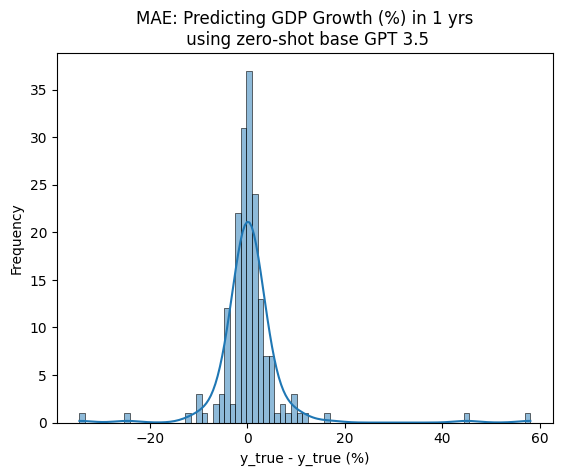

In [221]:
base_zero_shot_results_df['error'] = base_zero_shot_results_df['observed_gdp'] - base_zero_shot_results_df['predicted_gdp']
base_zero_shot_results_df['abs_error'] = np.abs(base_zero_shot_results_df['error'])
sns.histplot(base_zero_shot_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: Predicting GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot base GPT 3.5')
plt.show()

#### MAPE

In [222]:
base_zero_shot_results_mape = error_mape(base_zero_shot_results_df['predicted_gdp'],
                                         base_zero_shot_results_df['observed_gdp'])
print('Base zero shot MAPE = ', base_zero_shot_results_mape)

Base zero shot MAPE =  1.1247435217556148


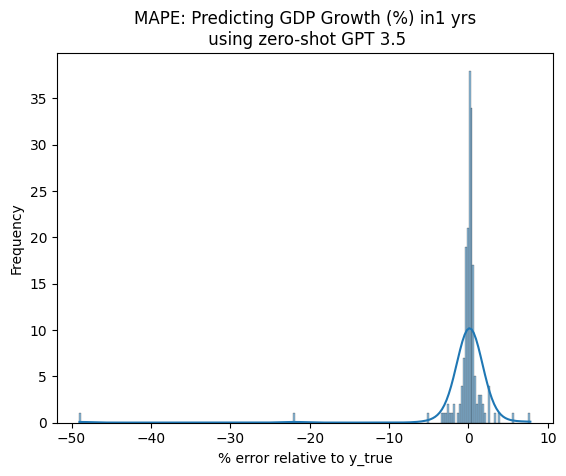

In [223]:
base_zero_shot_results_df['relative_error'] = (base_zero_shot_results_df['observed_gdp'] - base_zero_shot_results_df['predicted_gdp'])/base_zero_shot_results_df['observed_gdp']
sns.histplot(base_zero_shot_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot GPT 3.5')
plt.show()

#### Write raw results

In [224]:
temp = base_zero_shot_results_df
temp.head()

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
0,Albania,4.5,4.8,0.3,0.3,0.062500
1,Algeria,3.1,3.2,0.1,0.1,0.031250
2,Angola,2.8,3.0,0.2,0.2,0.066667
3,Antigua and Barbuda,5.2,8.5,3.3,3.3,0.388235
4,Argentina,5.0,5.0,0.0,0.0,0.000000


In [225]:
temp.columns = ["country", "base_zeroshot_predicted_gdp", "observed_gdp",
                "base_zeroshot_error", "base_zeroshot_abs_error", "base_zeroshot_relative_error"]
temp.to_csv(now_folder + '/' + 'base_zeroshot_results_df.csv')
temp.head()

,country,base_zeroshot_predicted_gdp,observed_gdp,base_zeroshot_error,base_zeroshot_abs_error,base_zeroshot_relative_error
0,Albania,4.5,4.8,0.3,0.3,0.062500
1,Algeria,3.1,3.2,0.1,0.1,0.031250
2,Angola,2.8,3.0,0.2,0.2,0.066667
3,Antigua and Barbuda,5.2,8.5,3.3,3.3,0.388235
4,Argentina,5.0,5.0,0.0,0.0,0.000000


### Using zeroshot results (GPT 3.5 updated 1105)

In [226]:
zero_shot_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,4.6,4.8
1,Algeria,3.2,3.2
2,Angola,3.0,3.0
3,Antigua and Barbuda,4.2,8.5
4,Argentina,5.2,5.0


#### MAE

In [227]:
zero_shot_results_mae = error_mae(zero_shot_results_df['predicted_gdp'],
                                  zero_shot_results_df['observed_gdp'])
print('Zero shot MAE = ', zero_shot_results_mae)

Zero shot MAE =  3.0530386740331488


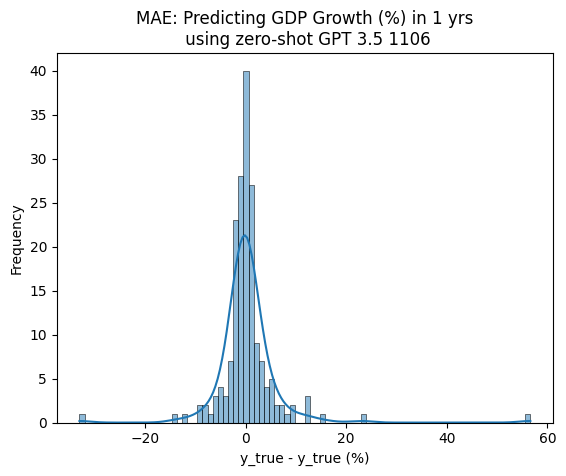

In [229]:
zero_shot_results_df['error'] = zero_shot_results_df['observed_gdp'] - zero_shot_results_df['predicted_gdp']
zero_shot_results_df['abs_error'] = np.abs(zero_shot_results_df['error'])
sns.histplot(zero_shot_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: Predicting GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot GPT 3.5 1106')
plt.show()

#### MAPE

In [230]:
zeroshot_mape = error_mape(zero_shot_results_df['predicted_gdp'],
                           zero_shot_results_df['observed_gdp'])
print('Zero-shot MAPE = ', zeroshot_mape)

Zero-shot MAPE =  1.1105677695398355


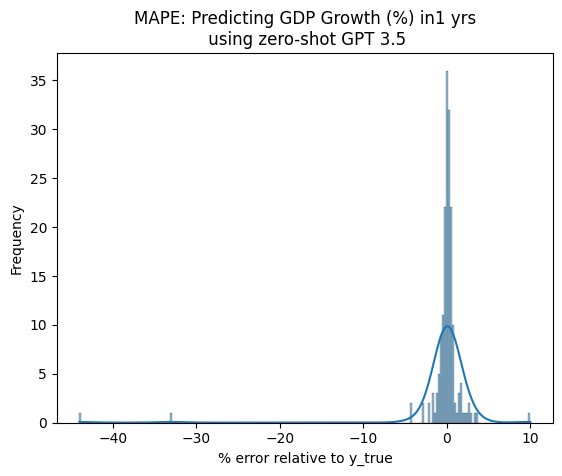

In [231]:
zero_shot_results_df['relative_error'] = (zero_shot_results_df['observed_gdp'] - zero_shot_results_df['predicted_gdp'])/zero_shot_results_df['observed_gdp']
sns.histplot(zero_shot_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using zero-shot GPT 3.5')
plt.show()

#### Write raw results

In [232]:
temp = zero_shot_results_df
temp.head()

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
0,Albania,4.6,4.8,0.2,0.2,0.041667
1,Algeria,3.2,3.2,0.0,0.0,0.000000
2,Angola,3.0,3.0,0.0,0.0,0.000000
3,Antigua and Barbuda,4.2,8.5,4.3,4.3,0.505882
4,Argentina,5.2,5.0,-0.2,0.2,-0.040000


In [233]:
temp.columns = ["country", "zeroshot_predicted_gdp", "observed_gdp",
                "zeroshot_error", "zeroshot_abs_error", "zeroshot_relative_error"]
temp.to_csv(now_folder + '/' + 'zeroshot_results_df.csv')
temp.head()

,country,zeroshot_predicted_gdp,observed_gdp,zeroshot_error,zeroshot_abs_error,zeroshot_relative_error
0,Albania,4.6,4.8,0.2,0.2,0.041667
1,Algeria,3.2,3.2,0.0,0.0,0.000000
2,Angola,3.0,3.0,0.0,0.0,0.000000
3,Antigua and Barbuda,4.2,8.5,4.3,4.3,0.505882
4,Argentina,5.2,5.0,-0.2,0.2,-0.040000


### Using finetuned results

In [234]:
finetuned_results_df.head()

,country,predicted_gdp,observed_gdp
0,Albania,7.9,4.8
1,Algeria,2.4,3.2
2,Angola,3.9,3.0
3,Antigua and Barbuda,3.7,8.5
4,Argentina,2.5,5.0


#### MAE

In [235]:
finetuned_mae = error_mae(finetuned_results_df['predicted_gdp'],
                          finetuned_results_df['observed_gdp'])
print('Finetuned MAE = ', finetuned_mae)

Finetuned MAE =  3.1397790055248618


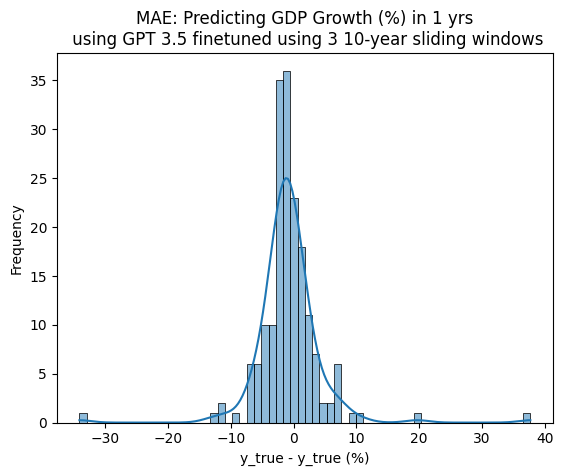

In [236]:
finetuned_results_df['error'] = finetuned_results_df['observed_gdp'] - finetuned_results_df['predicted_gdp']
finetuned_results_df['abs_error'] = np.abs(finetuned_results_df['error'])
sns.histplot(finetuned_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: Predicting GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

#### MAPE

In [237]:
finetuned_mape = error_mape(finetuned_results_df['predicted_gdp'],
                            finetuned_results_df['observed_gdp'])
print('Finetuned MAPE = ', finetuned_mape)

Finetuned MAPE =  1.1653236367109978


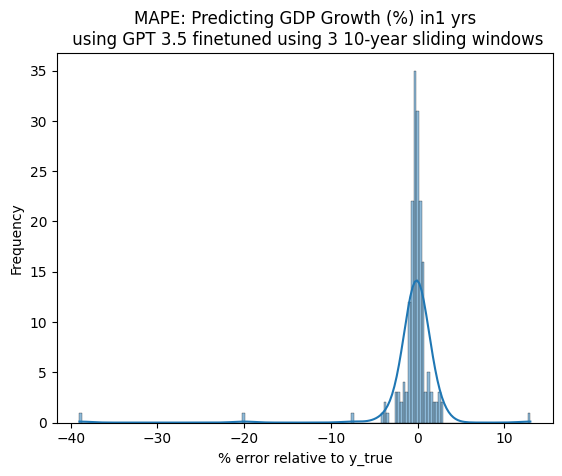

In [59]:
finetuned_results_df['relative_error'] = (finetuned_results_df['observed_gdp'] - finetuned_results_df['predicted_gdp'])/finetuned_results_df['observed_gdp']
sns.histplot(finetuned_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

#### Write raw results

In [60]:
temp = finetuned_results_df
temp.head()

,country,predicted_gdp,observed_gdp,error,abs_error,relative_error
0,Albania,7.9,4.8,-3.1,3.1,-0.645833
1,Algeria,2.4,3.2,0.8,0.8,0.250000
2,Angola,3.9,3.0,-0.9,0.9,-0.300000
3,Antigua and Barbuda,3.7,8.5,4.8,4.8,0.564706
4,Argentina,2.5,5.0,2.5,2.5,0.500000


In [61]:
temp.columns = ["country", "finetuned_predicted_gdp", "observed_gdp",
                "finetuned_error", "finetuned_abs_error", "finetuned_relative_error"]
temp.to_csv(now_folder + '/' + 'finetuned_results_df.csv')
temp.head()

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error
0,Albania,7.9,4.8,-3.1,3.1,-0.645833
1,Algeria,2.4,3.2,0.8,0.8,0.250000
2,Angola,3.9,3.0,-0.9,0.9,-0.300000
3,Antigua and Barbuda,3.7,8.5,4.8,4.8,0.564706
4,Argentina,2.5,5.0,2.5,2.5,0.500000


#### Further analysis

In [166]:
finetuned_results_df.nlargest(20, 'finetuned_abs_error')

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error
68,Guyana,24.6,62.3,37.7,37.7,0.605136
169,Ukraine,5.0,-29.1,-34.1,34.1,1.171821
55,Fiji,0.3,20.0,19.7,19.7,0.985000
152,Sri Lanka,5.4,-7.8,-13.2,13.2,1.692308
94,Libya,1.6,-9.6,-11.2,11.2,1.166667
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
27,Cabo Verde,6.2,17.0,10.8,10.8,0.635294
10,"Bahamas, The",4.9,14.4,9.5,9.5,0.659722
71,Hong Kong SAR,6.0,-3.5,-9.5,9.5,2.714286
137,Saint Lucia,8.3,15.7,7.4,7.4,0.471338


In [168]:
finetuned_results_df.nlargest(20, 'finetuned_relative_error')

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error
52,Estonia,6.0,-0.5,-6.5,6.5,13.000000
23,Brunei Darussalam,2.9,-1.6,-4.5,4.5,2.812500
71,Hong Kong SAR,6.0,-3.5,-9.5,9.5,2.714286
134,Russian Federation,3.2,-2.1,-5.3,5.3,2.523810
179,Yemen,-2.2,1.5,3.7,3.7,2.466667
153,Sudan,3.5,-2.5,-6.0,6.0,2.400000
163,Tonga,2.5,-2.0,-4.5,4.5,2.250000
108,Moldova,6.1,-5.0,-11.1,11.1,2.220000
14,Belarus,3.4,-3.7,-7.1,7.1,1.918919
69,Haiti,1.3,-1.7,-3.0,3.0,1.764706


### Using Previous Step

In [65]:
T_MINUS_1 = '2021'

In [66]:
t1_baseline_gdp_growth_df = rounded_gdp_growth_df[['country', T_MINUS_1, str(PREDICTION_YEAR)]]
t1_baseline_gdp_growth_df.head()

,country,2021,2022
0,Albania,8.9,4.8
1,Algeria,3.4,3.2
2,Angola,1.2,3.0
3,Antigua and Barbuda,6.6,8.5
4,Argentina,10.7,5.0


#### MAE

In [67]:
t_minus_1_mae = error_mae(t1_baseline_gdp_growth_df[T_MINUS_1], t1_baseline_gdp_growth_df[PREDICTION_YEAR])
print('T minus ' + str(PREDICTION_HORIZON) + ' MAE = ', t_minus_1_mae)

T minus 1 MAE =  4.299447513812155


<ipython-input-68-65f6a8b27212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['error'] = t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1]


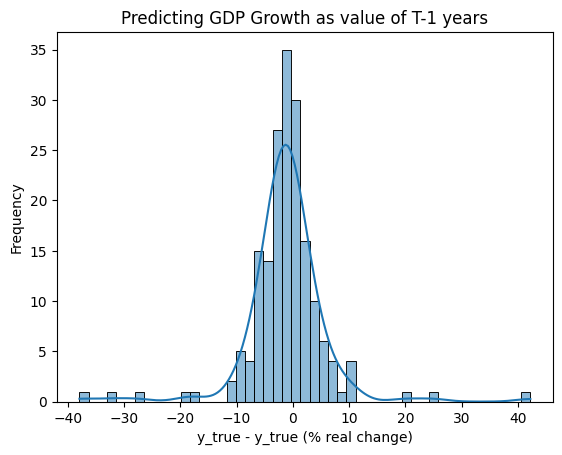

In [68]:
t1_baseline_gdp_growth_df['error'] = t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1]
sns.histplot(t1_baseline_gdp_growth_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as value of T-' + str(PREDICTION_HORIZON) + ' years')
plt.show()

In [69]:
t1_baseline_gdp_growth_df['abs_error'] = np.abs(t1_baseline_gdp_growth_df['error'])

<ipython-input-69-e4faecec4c43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['abs_error'] = np.abs(t1_baseline_gdp_growth_df['error'])


#### MAPE

In [70]:
t_minus_1_mape = error_mape(t1_baseline_gdp_growth_df[T_MINUS_1], t1_baseline_gdp_growth_df[PREDICTION_YEAR])
print('T minus ' + str(PREDICTION_HORIZON) + ' MAE = ', t_minus_1_mape)

T minus 1 MAE =  1.3901344850013484


<ipython-input-71-15622ccdbeb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_baseline_gdp_growth_df['relative_error'] = (t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1])/(t1_baseline_gdp_growth_df[PREDICTION_YEAR] + 0.000001)


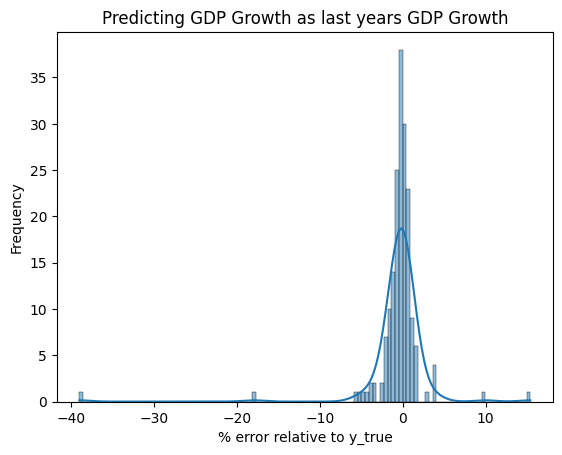

In [71]:
t1_baseline_gdp_growth_df['relative_error'] = (t1_baseline_gdp_growth_df[PREDICTION_YEAR] - t1_baseline_gdp_growth_df[T_MINUS_1])/(t1_baseline_gdp_growth_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(t1_baseline_gdp_growth_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as last years GDP Growth')
plt.show()

In [72]:
t1_baseline_gdp_growth_df[np.abs(t1_baseline_gdp_growth_df['relative_error']) > 10]

,country,2021,2022,error,abs_error,relative_error
52,Estonia,7.2,-0.5,-7.7,7.7,15.400031
126,Paraguay,4.0,0.1,-3.9,3.9,-38.999610
157,São Tomé and Príncipe,1.9,0.1,-1.8,1.8,-17.999820


#### Write raw results

In [73]:
temp = t1_baseline_gdp_growth_df
temp.head()

,country,2021,2022,error,abs_error,relative_error
0,Albania,8.9,4.8,-4.1,4.1,-0.854166
1,Algeria,3.4,3.2,-0.2,0.2,-0.062500
2,Angola,1.2,3.0,1.8,1.8,0.600000
3,Antigua and Barbuda,6.6,8.5,1.9,1.9,0.223529
4,Argentina,10.7,5.0,-5.7,5.7,-1.140000


In [74]:
temp.columns = ["country", "t_minus_1_gdp", "observed_gdp",
                "t_minus_1_error", "t_minus_1_abs_error", "t_minus_1_relative_error"]
temp.to_csv(now_folder + '/' + 't1_baseline_gdp_growth_df.csv')
temp.head()

,country,t_minus_1_gdp,observed_gdp,t_minus_1_error,t_minus_1_abs_error,t_minus_1_relative_error
0,Albania,8.9,4.8,-4.1,4.1,-0.854166
1,Algeria,3.4,3.2,-0.2,0.2,-0.062500
2,Angola,1.2,3.0,1.8,1.8,0.600000
3,Antigua and Barbuda,6.6,8.5,1.9,1.9,0.223529
4,Argentina,10.7,5.0,-5.7,5.7,-1.140000


### Using average growth rates so far


In [75]:
start_year = 2012
end_year = 2021

In [76]:
rounded_gdp_growth_df

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,-1.4,9.8,...,-3.3,8.9,4.8,3.6,3.3,3.4,3.5,3.5,3.5,Albania
1,-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,-1.9,4.8,...,-5.1,3.4,3.2,3.8,3.1,2.5,1.9,1.7,1.7,Algeria
2,2.4,-4.4,0.0,4.2,6.0,3.5,2.9,4.1,6.1,0.0,...,-5.6,1.2,3.0,1.3,3.3,3.4,3.5,3.5,3.6,Angola
3,8.2,3.8,-0.1,5.4,10.2,7.6,11.5,6.6,5.2,5.3,...,-17.5,6.6,8.5,5.6,5.4,4.2,2.8,2.8,2.8,Antigua and Barbuda
4,0.7,-5.7,-3.1,3.7,2.0,-7.0,7.1,2.5,-2.0,-7.0,...,-9.9,10.7,5.0,-2.5,2.8,3.3,3.0,2.8,2.5,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,-3.5,5.8,8.2,7.1,8.4,5.6,3.4,2.5,5.1,7.8,...,2.9,2.6,8.0,4.7,5.8,6.9,6.8,6.8,6.8,Vietnam
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.3,7.0,3.9,3.0,2.7,2.4,2.0,2.0,2.0,West Bank and Gaza
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.5,-1.0,1.5,-0.5,2.0,7.0,6.5,6.0,5.5,Yemen
180,3.9,6.6,-2.9,-1.1,-1.7,1.2,1.7,1.5,9.3,-3.7,...,-2.8,4.6,4.7,3.6,4.3,4.5,4.7,5.0,5.1,Zambia


In [77]:
last_x_years = rounded_gdp_growth_df.loc[:, str(start_year):str(end_year)]

# Calculate the mean along the rows
average_gdp_growth = last_x_years.mean(axis=1)

# Create a new column or Series in your DataFrame with the average GDP values
last_x_years_df = rounded_gdp_growth_df
last_x_years_df['average_growth'] = average_gdp_growth

In [78]:
last_x_years_df.sample(10)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2021,2022,2023,2024,2025,2026,2027,2028,country,average_growth
176,-4.9,-1.3,2.6,-9.9,5.2,0.9,6.1,4.8,6.5,-13.9,...,1.0,8.0,4.0,4.5,NaN,NaN,NaN,NaN,Venezuela,-11.23
152,5.8,5.3,5.2,3.3,6.7,5.0,4.3,1.5,2.7,2.3,...,3.5,-7.8,NaN,NaN,NaN,NaN,NaN,NaN,Sri Lanka,3.59
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.6,4.6,2.5,2.5,2.5,2.5,2.5,2.5,Azerbaijan,1.44
129,-6.0,-10.0,-4.8,5.6,-0.4,3.9,3.5,2.3,3.3,3.8,...,6.9,5.1,0.6,2.3,3.4,3.2,3.1,3.1,Poland,3.39
64,15.1,1.4,4.1,3.3,4.0,6.0,7.4,9.1,2.9,3.8,...,4.7,6.4,3.9,3.8,3.5,3.2,2.7,2.7,Grenada,1.90
135,-3.6,2.5,-2.5,6.0,13.0,4.4,5.5,-0.3,0.3,-5.7,...,10.9,8.2,6.2,7.0,7.0,7.3,7.3,7.3,Rwanda,6.38
137,-0.5,5.1,2.1,4.1,8.0,12.6,14.4,3.9,13.9,9.0,...,11.3,15.7,3.2,2.3,2.3,1.8,1.5,1.5,Saint Lucia,-0.39
71,10.3,9.2,2.9,6.0,10.0,0.7,11.1,13.4,8.5,2.3,...,6.4,-3.5,4.4,2.9,2.9,2.7,2.6,2.4,Hong Kong SAR,1.70
167,-0.8,4.4,3.4,4.8,6.8,4.3,6.9,10.0,2.1,0.3,...,11.4,5.5,4.0,3.0,3.2,3.2,3.2,3.2,"Türkiye, Republic of",5.22
128,5.1,3.4,3.6,1.9,-7.3,-7.3,3.4,4.3,6.8,6.2,...,5.7,7.6,5.3,5.9,6.1,6.2,6.3,6.4,Philippines,4.89


In [79]:
last_x_years_df[last_x_years_df['country']=='India']

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2021,2022,2023,2024,2025,2026,2027,2028,country,average_growth
74,5.3,6.0,3.5,7.3,3.8,5.3,4.8,4.0,9.6,5.9,...,9.1,7.2,6.3,6.3,6.3,6.3,6.3,6.3,India,5.61


#### MAE

In [80]:
last_x_average_mae = error_mae(last_x_years_df['average_growth'], last_x_years_df[PREDICTION_YEAR])
print('Last X average MAE = ', last_x_average_mae)

Last X average MAE =  3.4760773480662976


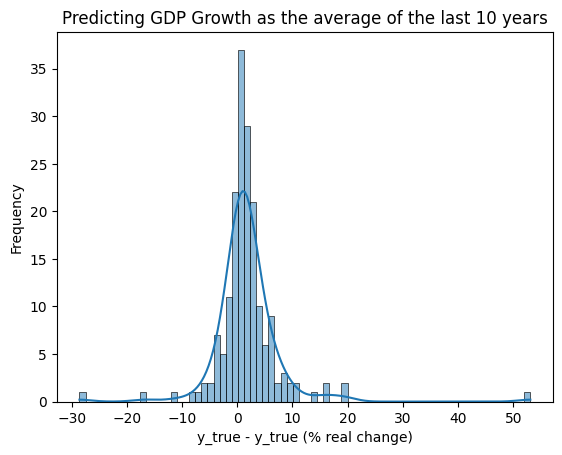

In [81]:
last_x_years_df['error'] = last_x_years_df[PREDICTION_YEAR] - last_x_years_df['average_growth']
sns.histplot(last_x_years_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as the average of the last 10 years')
plt.show()

In [82]:
last_x_years_df['abs_error'] = np.abs(last_x_years_df['error'])

#### MAPE

In [83]:
last_x_average_mape = error_mape(last_x_years_df['average_growth'], last_x_years_df[PREDICTION_YEAR])
print('Last X average MAPE = ', last_x_average_mape)

Last X average MAPE =  1.0236957431691505


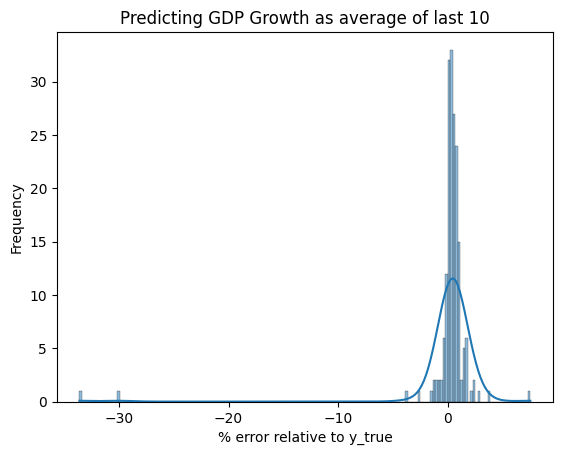

In [84]:
last_x_years_df['relative_error'] = (last_x_years_df[PREDICTION_YEAR] - last_x_years_df['average_growth'])/(last_x_years_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(last_x_years_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as average of last 10')
plt.show()

#### Write raw results

In [85]:
temp = last_x_years_df[["country", "average_growth", "2022", "error", "abs_error", "relative_error"]]
temp.head()

,country,average_growth,2022,error,abs_error,relative_error
0,Albania,2.52,4.8,2.28,2.28,0.475000
1,Algeria,1.88,3.2,1.32,1.32,0.412500
2,Angola,1.00,3.0,2.00,2.00,0.666666
3,Antigua and Barbuda,1.92,8.5,6.58,6.58,0.774118
4,Argentina,-0.15,5.0,5.15,5.15,1.030000


In [86]:
temp.columns = ["country", "avg_growth_10y_prediction", "observed_gdp",
                "avg_growth_10y_error", "avg_growth_10y_error", "avg_growth_10y_relative_error"]
temp.to_csv(now_folder + '/' + 'avg_growth_10y_df.csv')
temp.head()

,country,avg_growth_10y_prediction,observed_gdp,avg_growth_10y_error,avg_growth_10y_error,avg_growth_10y_relative_error
0,Albania,2.52,4.8,2.28,2.28,0.475000
1,Algeria,1.88,3.2,1.32,1.32,0.412500
2,Angola,1.00,3.0,2.00,2.00,0.666666
3,Antigua and Barbuda,1.92,8.5,6.58,6.58,0.774118
4,Argentina,-0.15,5.0,5.15,5.15,1.030000


### Using xgboost

In [87]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [88]:
xgb_start_year = 2001
xgb_end_year = 2022
last_x_years = rounded_gdp_growth_df.loc[:, str(xgb_start_year):str(xgb_end_year)]
last_x_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,...,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9,4.8
1,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,...,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4,3.2
2,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,...,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0
3,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,...,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6,8.5
4,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,...,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7,5.0


In [89]:
data = rounded_gdp_growth_df

# Assuming the 'Country' column is the index
data.set_index('country', inplace=True)

data = data.loc[:, str(xgb_start_year):str(xgb_end_year)]
data.head()

# # Extract features (X) and target variable (y)
# X = data.drop('2022', axis=1)  # Features from 2001 to 2021
# y = data['2022']  # Target variable for prediction

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X.drop('2022', axis=1),
#                                                     data['2021'],y, test_size=0.2, random_state=42)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Albania,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,...,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9,4.8
Algeria,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,...,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4,3.2
Angola,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,...,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0
Antigua and Barbuda,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,...,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6,8.5
Argentina,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,...,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7,5.0


In [90]:
X_train = data.loc[:, str(xgb_start_year):str(xgb_end_year-2)]
y_train = data.loc[:, str(xgb_end_year-1)]
X_test = data.loc[:, str(xgb_start_year+1):str(xgb_end_year-1)]
y_test = data.loc[:, str(xgb_end_year)]

In [91]:
X_train.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
country,,,,,,,,,,,,,,,,,,,,
Albania,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,2.5,1.4,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3
Algeria,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,2.9,3.4,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1
Angola,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,3.5,8.5,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6
Antigua and Barbuda,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,-2.0,3.4,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5
Argentina,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,6.0,-1.0,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9


In [92]:
y_train.head()

country
Albania                 8.9
Algeria                 3.4
Angola                  1.2
Antigua and Barbuda     6.6
Argentina              10.7
Name: 2021, dtype: float64

In [93]:
X_test.head()

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,
Albania,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,3.7,2.5,1.4,1.0,1.8,2.2,3.3,3.8,4.0,2.1,-3.3,8.9
Algeria,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,3.6,2.9,3.4,2.8,3.8,3.7,3.2,1.4,1.2,1.0,-5.1,3.4
Angola,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,4.9,3.5,8.5,5.0,4.8,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2
Antigua and Barbuda,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,-7.8,-2.0,3.4,-0.6,3.8,3.8,5.5,3.1,6.8,4.3,-17.5,6.6
Argentina,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,10.1,6.0,-1.0,2.4,-2.5,2.7,-2.1,2.8,-2.6,-2.0,-9.9,10.7


In [94]:
y_test.head()

country
Albania                4.8
Algeria                3.2
Angola                 3.0
Antigua and Barbuda    8.5
Argentina              5.0
Name: 2022, dtype: float64

In [95]:
# Create an XGBoost regressor
xgb_model = XGBRegressor()

# rename columns to make them match
x_col = [str(i+1) for i in np.arange(20)]
print(x_col)
X_train.columns = x_col
X_test.columns = x_col

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [96]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set (2022)
xgb_predictions = xgb_model.predict(X_test)

In [97]:
list(xgb_predictions)[0:10]

[14.247793,
 3.7744305,
 -0.5678999,
 7.9964404,
 8.394354,
 3.6617057,
 5.9400067,
 4.8008904,
 3.841447,
 0.29972857]

In [98]:
# Add the predicted values to the original DataFrame
data['xgboost_2022'] = xgb_predictions
xgb_df = data
xgb_df.to_csv('xgboost_predictions_gdp_growth_1y.csv')

<ipython-input-98-d6856d29f3e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['xgboost_2022'] = xgb_predictions


#### MAE

In [99]:
xgboost_mae = error_mae(list(xgb_predictions), y_test)
print('xgboost average MAE = ', xgboost_mae)

xgboost average MAE =  4.832673918126532


<ipython-input-100-1da39da33be7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_df['error'] = xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022']


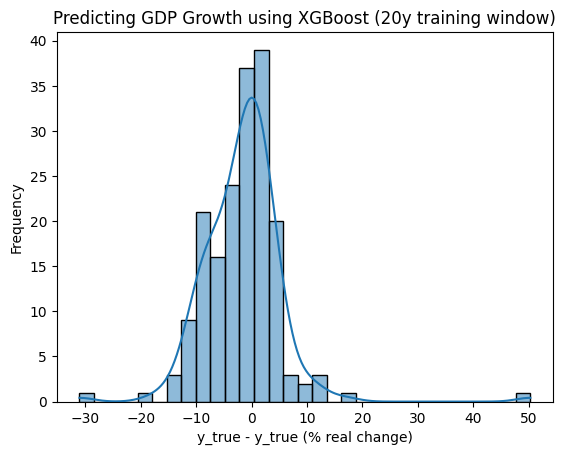

In [100]:
xgb_df['error'] = xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022']
sns.histplot(xgb_df['error'], kde=True)
plt.xlabel('y_true - y_true (% real change)')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth using XGBoost (20y training window)')
plt.show()

#### MAPE

In [101]:
xgboost_mape = error_mape(list(xgb_predictions), y_test)
print('xgboost average MAPE = ', xgboost_mape)

xgboost average MAPE =  1.8399706667658944


<ipython-input-102-2d7ef1166d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_df['relative_error'] = (xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022'])/(xgb_df[PREDICTION_YEAR] + 0.000001)


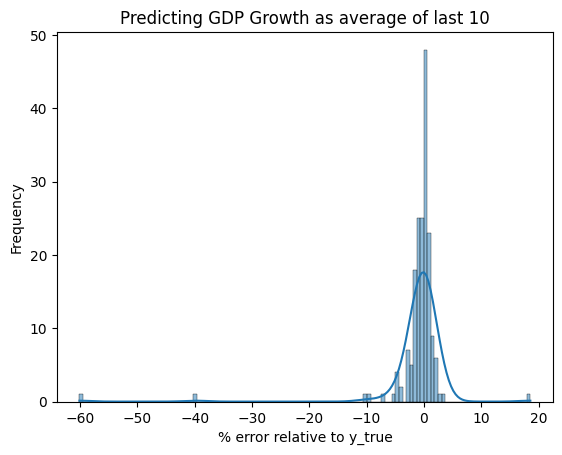

In [102]:
xgb_df['relative_error'] = (xgb_df[PREDICTION_YEAR] - xgb_df['xgboost_2022'])/(xgb_df[PREDICTION_YEAR] + 0.000001)
sns.histplot(xgb_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('Predicting GDP Growth as average of last 10')
plt.show()

In [103]:
xgb_df.to_csv('xgboost_predictions_gdp_growth_1y.csv')

### Expert Forecasts - IMF Oct 2021 Predictions

In [107]:
imf_df = pd.read_csv('imf_growth_forecasts_oct_2021.csv')
imf_df.head(5)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2018,2019,2020,2021,2022,2023,2024,2025,Estimates Start After
0,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,2019.0
1,Albania,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",4.071,2.174,-3.311,5.300,4.500,4.100,3.700,3.486,2020.0
2,Algeria,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.200,0.800,-4.900,3.410,1.947,1.706,0.814,0.122,2019.0
3,Andorra,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",1.589,2.017,-11.969,5.500,4.800,2.700,2.222,1.540,2020.0
4,Angola,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",-2.045,-0.535,-5.385,-0.655,2.364,3.328,3.657,3.812,2020.0


In [108]:
cleaned_imf_df = imf_df[~imf_df['2022'].isnull()]
cleaned_imf_df = cleaned_imf_df[["Country", "2022"]]
cleaned_imf_df.columns = ['country', 'imf_2022_forecast']
print(cleaned_imf_df.shape)
cleaned_imf_df.head()

(192, 2)


,country,imf_2022_forecast
1,Albania,4.500
2,Algeria,1.947
3,Andorra,4.800
4,Angola,2.364
5,Antigua and Barbuda,7.019


In [109]:
print(cleaned_imf_df.shape)
imf_results_df = pd.merge(rounded_gdp_growth_df.reset_index()[["country", "2022"]],
                          cleaned_imf_df, how="inner", on="country")
print(imf_results_df.shape)
imf_results_df.head()

(192, 2)
(164, 3)


,country,2022,imf_2022_forecast
0,Albania,4.8,4.500
1,Algeria,3.2,1.947
2,Angola,3.0,2.364
3,Antigua and Barbuda,8.5,7.019
4,Argentina,5.0,2.465


#### MAE

In [110]:
imf_mae = error_mae(imf_results_df['imf_2022_forecast'],
                    imf_results_df['2022'])
print('IMF MAE = ', imf_mae)

IMF MAE =  2.5792256097560977


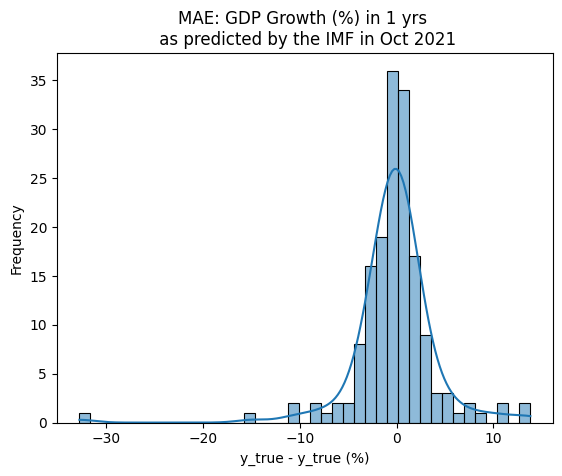

In [111]:
imf_results_df['error'] = imf_results_df['2022'] - imf_results_df['imf_2022_forecast']
imf_results_df['abs_error'] = np.abs(imf_results_df['error'])
sns.histplot(imf_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (%)')
plt.ylabel('Frequency')
plt.title('MAE: GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs \n as predicted by the IMF in Oct 2021')
plt.show()

#### MAPE

In [112]:
imf_mape = error_mape(imf_results_df['imf_2022_forecast'],
                      imf_results_df['2022'])
print('IMF MAPE = ', imf_mape)

IMF MAPE =  0.8955265764057417


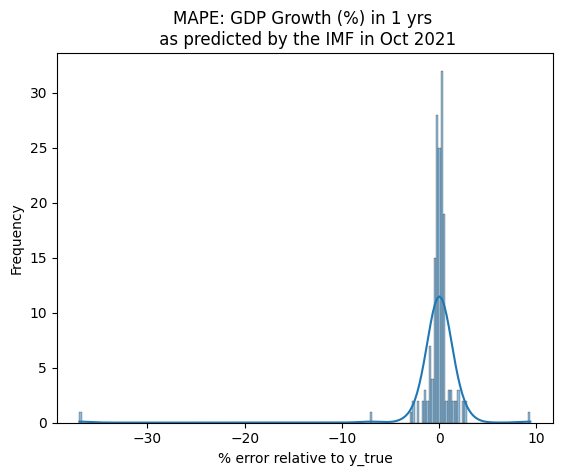

In [113]:
imf_results_df['relative_error'] = (imf_results_df['2022'] - imf_results_df['imf_2022_forecast'])/imf_results_df['2022']
imf_results_df['abs_error'] = np.abs(imf_results_df['error'])
sns.histplot(imf_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: GDP Growth (%) in ' + str(PREDICTION_HORIZON) + ' yrs \n as predicted by the IMF in Oct 2021')
plt.show()

In [114]:
imf_results_df.head()

,country,2022,imf_2022_forecast,error,abs_error,relative_error
0,Albania,4.8,4.500,0.300,0.300,0.062500
1,Algeria,3.2,1.947,1.253,1.253,0.391563
2,Angola,3.0,2.364,0.636,0.636,0.212000
3,Antigua and Barbuda,8.5,7.019,1.481,1.481,0.174235
4,Argentina,5.0,2.465,2.535,2.535,0.507000


In [115]:
imf_results_df.to_csv(now_folder + '/' + 'imf_results.csv')

In [116]:
imf_results_df.nlargest(20, 'abs_error')

,country,2022,imf_2022_forecast,error,abs_error,relative_error
151,Ukraine,-29.1,3.636,-32.736,32.736,1.124948
84,Libya,-9.6,5.252,-14.852,14.852,1.547083
49,Fiji,20.0,6.195,13.805,13.805,0.690250
61,Guyana,62.3,48.709,13.591,13.591,0.218154
136,Sri Lanka,-7.8,3.296,-11.096,11.096,1.422564
158,Venezuela,8.0,-3.000,11.000,11.000,1.375000
26,Cabo Verde,17.0,6.504,10.496,10.496,0.617412
97,Moldova,-5.0,5.172,-10.172,10.172,2.034400
46,Equatorial Guinea,3.2,-5.626,8.826,8.826,2.758125
133,Solomon Islands,-4.1,4.395,-8.495,8.495,2.071951


## Further Analysis

#### Correlation of errors between methods

In [121]:
results_df = pd.merge(finetuned_results_df, zero_shot_results_df, how='inner', on='country')
results_df

,country,finetuned_predicted_gdp,observed_gdp_x,finetuned_error,finetuned_abs_error,finetuned_relative_error,zeroshot_predicted_gdp,observed_gdp_y,zeroshot_error,zeroshot_abs_error,zeroshot_relative_error
0,Albania,7.9,4.8,-3.1,3.1,-0.645833,4.6,4.8,0.2,0.2,0.041667
1,Algeria,2.4,3.2,0.8,0.8,0.250000,3.2,3.2,0.0,0.0,0.000000
2,Angola,3.9,3.0,-0.9,0.9,-0.300000,3.0,3.0,0.0,0.0,0.000000
3,Antigua and Barbuda,3.7,8.5,4.8,4.8,0.564706,4.2,8.5,4.3,4.3,0.505882
4,Argentina,2.5,5.0,2.5,2.5,0.500000,5.2,5.0,-0.2,0.2,-0.040000
...,...,...,...,...,...,...,...,...,...,...,...
176,Vietnam,5.7,8.0,2.3,2.3,0.287500,6.8,8.0,1.2,1.2,0.150000
177,West Bank and Gaza,5.0,3.9,-1.1,1.1,-0.282051,4.3,3.9,-0.4,0.4,-0.102564
178,Yemen,-2.2,1.5,3.7,3.7,2.466667,2.7,1.5,-1.2,1.2,-0.800000
179,Zambia,4.1,4.7,0.6,0.6,0.127660,5.2,4.7,-0.5,0.5,-0.106383


In [125]:
last_x_years_df.head()
last_x_years_df['avg_x_years_average_growth'] = last_x_years_df['average_growth']
last_x_years_df['avg_x_years_error'] = last_x_years_df['error']
last_x_years_df['avg_x_years_relative_error'] = last_x_years_df['relative_error']
# finetuned_results_df.head()

In [131]:
last_x_years_df = last_x_years_df.reset_index()

In [132]:
analysis_df = pd.merge(finetuned_results_df,
                       last_x_years_df[['country', 'avg_x_years_average_growth',
                                        'avg_x_years_error', 'avg_x_years_relative_error']],
                       on = 'country')
analysis_df

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error,avg_x_years_average_growth,avg_x_years_error,avg_x_years_relative_error
0,Albania,7.9,4.8,-3.1,3.1,-0.645833,2.52,2.28,0.475000
1,Algeria,2.4,3.2,0.8,0.8,0.250000,1.88,1.32,0.412500
2,Angola,3.9,3.0,-0.9,0.9,-0.300000,1.00,2.00,0.666666
3,Antigua and Barbuda,3.7,8.5,4.8,4.8,0.564706,1.92,6.58,0.774118
4,Argentina,2.5,5.0,2.5,2.5,0.500000,-0.15,5.15,1.030000
...,...,...,...,...,...,...,...,...,...
176,Vietnam,5.7,8.0,2.3,2.3,0.287500,5.85,2.15,0.268750
177,West Bank and Gaza,5.0,3.9,-1.1,1.1,-0.282051,2.29,1.61,0.412820
178,Yemen,-2.2,1.5,3.7,3.7,2.466667,-4.21,5.71,3.806664
179,Zambia,4.1,4.7,0.6,0.6,0.127660,3.48,1.22,0.259574


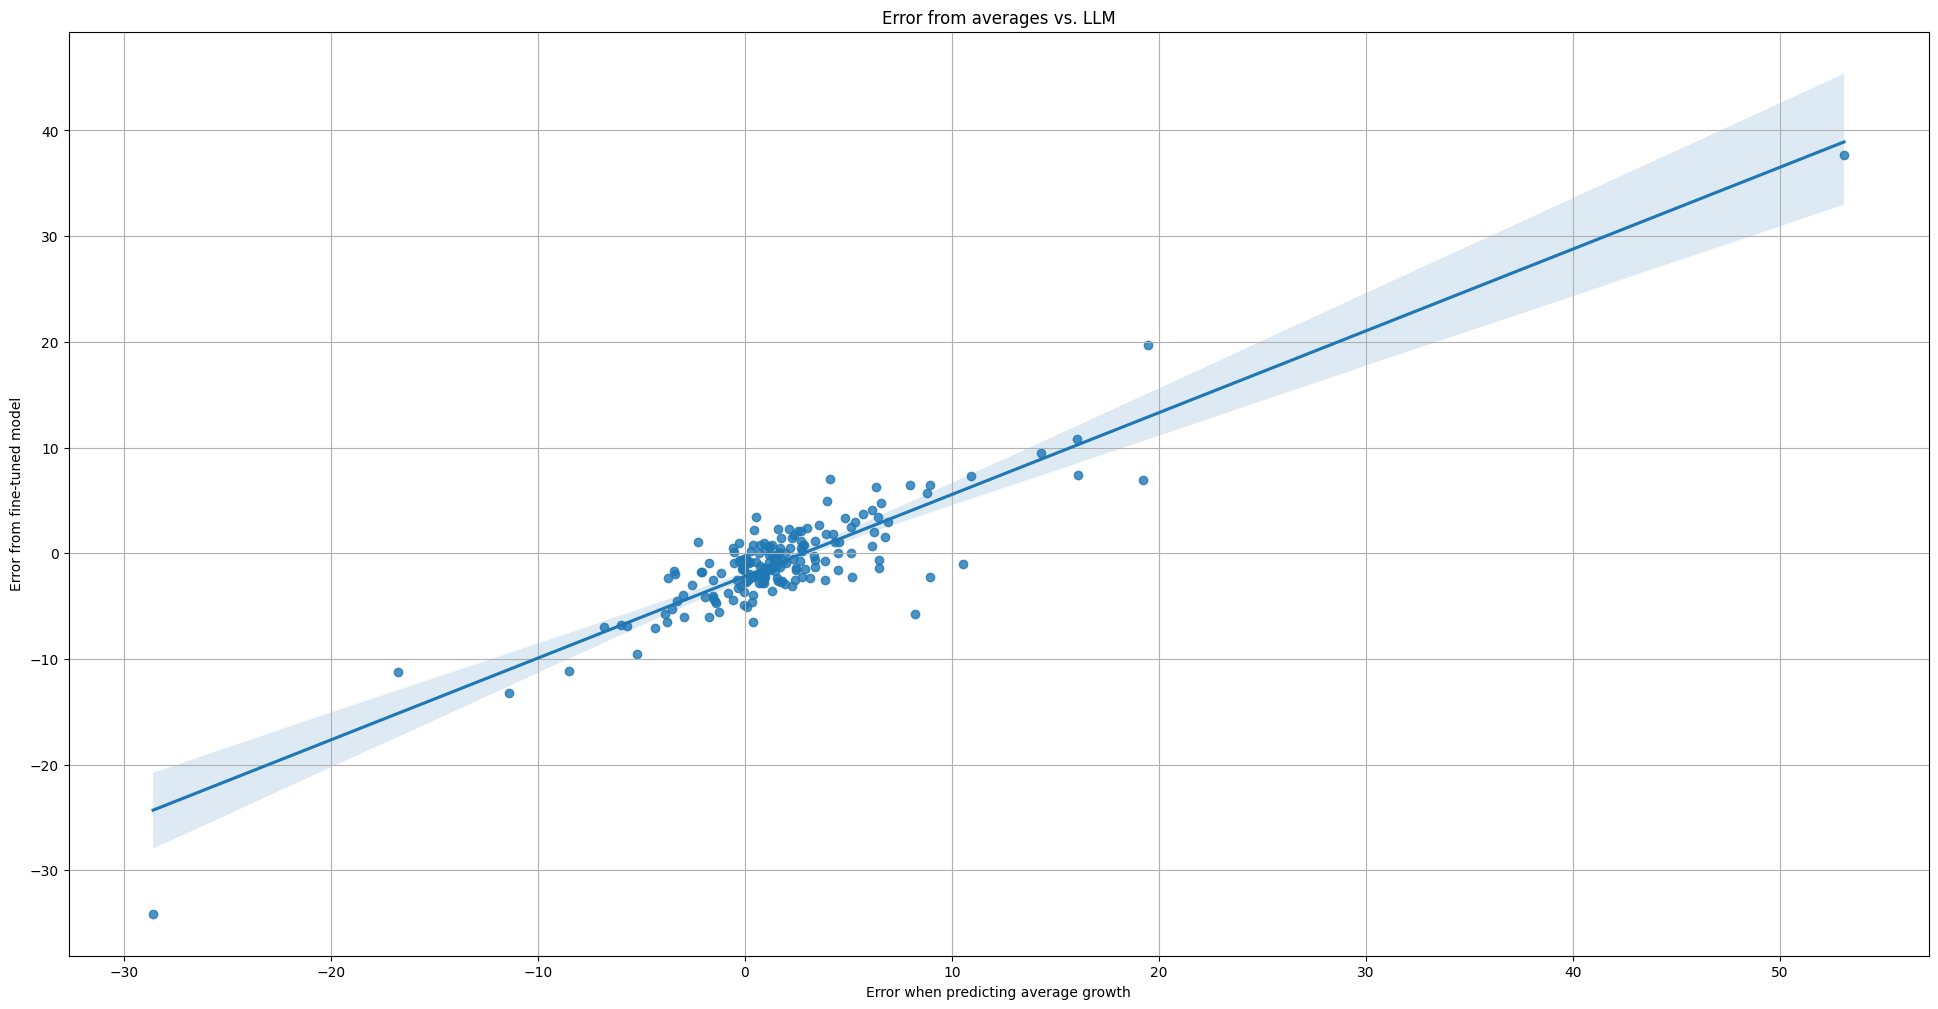

In [134]:
# Scatter plot using seaborn
plt.figure(figsize=(24, 12))
scatter_plot = sns.regplot(x='avg_x_years_error', y='finetuned_error', data=analysis_df)
plt.title('Error from averages vs. LLM')
plt.xlabel('Error when predicting average growth')
plt.ylabel('Error from fine-tuned model')
# # Add labels for each point
# for line in range(0, analysis_df.shape[0]):
#   scatter_plot.text(analysis_df['avg_x_years_error'][line] + 0.1,
#                     analysis_df['error'][line],
#                     analysis_df['country'][line],
#                     horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.grid(True)
plt.show()

In [135]:
# Calculate and print the correlation coefficient
from scipy.stats import pearsonr
correlation_coefficient, _ = pearsonr(analysis_df['avg_x_years_error'], analysis_df['finetuned_error'])
print(f'Correlation Coefficient: {correlation_coefficient:.2f}')

Correlation Coefficient: 0.90


#### Biggest countries

In [239]:
gdp_df = pd.read_csv("cleaned_gdp_df_countries.csv")
gdp_df.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
0,1.9,2.2,2.3,2.3,2.3,2.3,2.6,2.6,2.5,2.8,...,15.2,18.0,19.1,23.0,25.3,26.4,27.8,29.5,31.4,Albania
1,42.3,44.4,44.8,47.5,51.5,61.1,61.5,63.3,51.7,52.6,...,145.7,163.1,195.1,224.1,239.2,247.7,255.3,259.3,262.8,Algeria
2,6.6,6.2,6.2,6.5,6.9,8.5,7.9,9.0,9.8,11.4,...,57.1,74.9,122.8,93.8,92.9,96.9,100.8,106.4,111.8,Angola
3,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.3,0.4,0.4,...,1.4,1.6,1.8,1.9,2.1,2.3,2.4,2.5,2.6,Antigua and Barbuda
4,233.7,189.8,94.2,116.3,130.5,98.6,118.6,121.6,142.4,91.4,...,389.1,487.4,630.6,621.8,632.6,635.9,660.3,695.3,728.1,Argentina


In [240]:
largest_countries = list(gdp_df.nlargest(50, "2021").country)
largest_countries[:10]

['United States',
 "China, People's Republic of",
 'Japan',
 'Germany',
 'India',
 'United Kingdom',
 'France',
 'Italy',
 'Canada',
 'Korea, Republic of']

#### Error in biggest countries

In [136]:
analysis_df50 = analysis_df[analysis_df.country.isin(largest_countries)]
analysis_df50.head()

,country,finetuned_predicted_gdp,observed_gdp,finetuned_error,finetuned_abs_error,finetuned_relative_error,avg_x_years_average_growth,avg_x_years_error,avg_x_years_relative_error
4,Argentina,2.5,5.0,2.5,2.5,0.500000,-0.15,5.15,1.030000
7,Australia,3.9,3.7,-0.2,0.2,-0.054054,2.41,1.29,0.348649
8,Austria,3.0,4.8,1.8,1.8,0.375000,0.87,3.93,0.818750
12,Bangladesh,7.1,7.1,0.0,0.0,0.000000,6.44,0.66,0.092958
15,Belgium,6.1,3.2,-2.9,2.9,-0.906250,1.27,1.93,0.603125


In [138]:
finetuned_mae_analysis_df50 = error_mae(analysis_df50['finetuned_predicted_gdp'],
                                        analysis_df50['observed_gdp'])
print('Finetuned MAE of 50 largest countries = ', finetuned_mae_analysis_df50)

Finetuned MAE of 50 largest countries =  1.81


In [139]:
finetuned_mape_analysis_df50 = error_mape(analysis_df50['finetuned_predicted_gdp'],
                                          analysis_df50['observed_gdp'])
print('Finetuned MAPE of 50 largest countries = ', finetuned_mape_analysis_df50)

Finetuned MAPE of 50 largest countries =  0.5483767336811165


<ipython-input-140-6862b8c2b675>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df50['relative_error'] = (analysis_df50['observed_gdp'] - analysis_df50['finetuned_predicted_gdp'])/analysis_df50['observed_gdp']


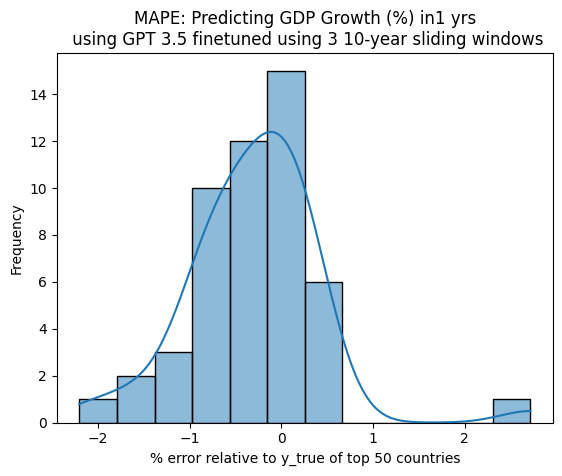

In [140]:
analysis_df50['relative_error'] = (analysis_df50['observed_gdp'] - analysis_df50['finetuned_predicted_gdp'])/analysis_df50['observed_gdp']
sns.histplot(analysis_df50['relative_error'], kde=True)
plt.xlabel('% error relative to y_true of top 50 countries')
plt.ylabel('Frequency')
plt.title('MAPE: Predicting GDP Growth (%) in' + str(PREDICTION_HORIZON) + ' yrs\n using GPT 3.5 finetuned using 3 10-year sliding windows')
plt.show()

In [141]:
np.mean(np.abs(analysis_df50['avg_x_years_error']))

2.2616

In [142]:
np.mean(np.abs(analysis_df50['avg_x_years_relative_error']))

0.4950707885091954

##### IMF in top 50

In [155]:
np.mean(np.abs(imf_results_df[imf_results_df['country'].isin(largest_countries)].error))

1.5141956521739126

In [150]:
np.mean(np.abs(imf_results_df[imf_results_df['country'].isin(largest_countries)].relative_error))

0.40355066011377816

##### XGBoost in top 50

In [157]:
xgb_results_df = xgb_df.reset_index()
xgb_results_df.head()

,country,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2016,2017,2018,2019,2020,2021,2022,xgboost_2022,error,relative_error
0,Albania,8.3,4.5,5.5,5.5,5.5,5.9,6.0,7.5,3.4,...,3.3,3.8,4.0,2.1,-3.3,8.9,4.8,14.247793,-9.447793,-1.968290
1,Algeria,3.0,5.6,7.2,4.3,5.9,1.7,3.4,2.4,1.6,...,3.2,1.4,1.2,1.0,-5.1,3.4,3.2,3.774431,-0.574431,-0.179509
2,Angola,4.2,13.7,3.0,11.0,15.0,11.5,14.0,11.2,0.9,...,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0,-0.567900,3.567900,1.189300
3,Antigua and Barbuda,-4.5,1.0,6.1,5.8,6.5,12.7,9.3,0.0,-12.0,...,5.5,3.1,6.8,4.3,-17.5,6.6,8.5,7.996440,0.503560,0.059242
4,Argentina,-4.4,-10.9,9.0,8.9,8.9,8.0,9.0,4.1,-5.9,...,-2.1,2.8,-2.6,-2.0,-9.9,10.7,5.0,8.394354,-3.394354,-0.678871


In [158]:
np.mean(np.abs(xgb_results_df[xgb_results_df['country'].isin(largest_countries)].error))

3.8378727140873665

In [159]:
np.mean(np.abs(xgb_results_df[xgb_results_df['country'].isin(largest_countries)].relative_error))

1.0132658056305817

##### Last year value

In [160]:
t1_baseline_gdp_growth_df.head()

,country,t_minus_1_gdp,observed_gdp,t_minus_1_error,t_minus_1_abs_error,t_minus_1_relative_error
0,Albania,8.9,4.8,-4.1,4.1,-0.854166
1,Algeria,3.4,3.2,-0.2,0.2,-0.062500
2,Angola,1.2,3.0,1.8,1.8,0.600000
3,Antigua and Barbuda,6.6,8.5,1.9,1.9,0.223529
4,Argentina,10.7,5.0,-5.7,5.7,-1.140000


In [162]:
np.mean(np.abs(t1_baseline_gdp_growth_df[t1_baseline_gdp_growth_df['country'].isin(largest_countries)].t_minus_1_error))

3.228

In [161]:
np.mean(np.abs(t1_baseline_gdp_growth_df[t1_baseline_gdp_growth_df['country'].isin(largest_countries)].t_minus_1_relative_error))

0.9028064146558973

##### zero shot results (updated 1106)

In [163]:
zero_shot_results_df.head()

,country,zeroshot_predicted_gdp,observed_gdp,zeroshot_error,zeroshot_abs_error,zeroshot_relative_error
0,Albania,4.6,4.8,0.2,0.2,0.041667
1,Algeria,3.2,3.2,0.0,0.0,0.000000
2,Angola,3.0,3.0,0.0,0.0,0.000000
3,Antigua and Barbuda,4.2,8.5,4.3,4.3,0.505882
4,Argentina,5.2,5.0,-0.2,0.2,-0.040000


In [164]:
np.mean(np.abs(zero_shot_results_df[zero_shot_results_df['country'].isin(largest_countries)].zeroshot_error))

1.4779999999999998

In [165]:
np.mean(np.abs(zero_shot_results_df[zero_shot_results_df['country'].isin(largest_countries)].zeroshot_relative_error))

0.3711775794849555

##### zero shot results (base)

In [241]:
base_zero_shot_results_df.head()

,country,base_zeroshot_predicted_gdp,observed_gdp,base_zeroshot_error,base_zeroshot_abs_error,base_zeroshot_relative_error
0,Albania,4.5,4.8,0.3,0.3,0.062500
1,Algeria,3.1,3.2,0.1,0.1,0.031250
2,Angola,2.8,3.0,0.2,0.2,0.066667
3,Antigua and Barbuda,5.2,8.5,3.3,3.3,0.388235
4,Argentina,5.0,5.0,0.0,0.0,0.000000


In [242]:
np.mean(np.abs(base_zero_shot_results_df[base_zero_shot_results_df['country'].isin(largest_countries)].base_zeroshot_error))

1.5551020408163263

In [243]:
np.mean(np.abs(base_zero_shot_results_df[base_zero_shot_results_df['country'].isin(largest_countries)].base_zeroshot_relative_error))

0.39219123634878883

### Expert predictions

For now:
- IMF (how will we compare the $ amount??)

We should pull in others eventually
- World Bank
- The Economist
- Fitch
- Various central banks

#### Clean IMF Forecast Data from Fall 2021

In [ ]:
raw_2021_imf_forecast = pd.read_csv('imf_economic_outlook_Oct2021all.csv')
print(raw_2021_imf_forecast.shape)
raw_2021_imf_forecast.head()

(8823, 57)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,270.22","1,319.90","1,288.87",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,327.69","1,469.60","1,547.29",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.401,18.876,20.136,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,77.406,81.873,80.912,NaN,NaN,NaN,NaN,NaN,NaN,2019.0


In [ ]:
imf_2021_forecast = raw_2021_imf_forecast[raw_2021_imf_forecast['Subject Descriptor'] ==
                                          "Gross domestic product, current prices"]
print(imf_2021_forecast.shape[0])
imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Units'] == "U.S. dollars"]
print(imf_2021_forecast.shape[0])
# imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Scale'] == "Billions"]
# print(imf_2021_forecast.shape[0])
# imf_2021_forecast = imf_2021_forecast[imf_2021_forecast['Country/Series-specific Notes'].str.contains("IMF")]
# print(imf_2021_forecast.shape[0])
imf_2021_forecast = imf_2021_forecast[imf_2021_forecast.Country.isin(cleaned_gdp_countries.country)]
print(imf_2021_forecast.shape[0])
imf_2021_forecast

588
196
127


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
48,914,ALB,NGDPD,Albania,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1.946,...,15.147,15.283,14.828,16.77,18.012,18.931,20.026,21.15,22.308,2020.0
93,612,DZA,NGDPD,Algeria,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",42.346,...,175.367,171.07,147.6,163.812,168.195,172.094,173.719,174.376,175.228,2019.0
183,614,AGO,NGDPD,Angola,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",6.639,...,101.353,84.516,58.376,70.339,74.953,79.304,84.614,90.888,96.437,2020.0
228,311,ATG,NGDPD,Antigua and Barbuda,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",0.131,...,1.605,1.687,1.37,1.405,1.534,1.652,1.759,1.855,1.943,2019.0
273,213,ARG,NGDPD,Argentina,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",233.696,...,524.431,451.815,389.064,455.172,483.765,476.485,488.269,511.523,536.229,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,111,USA,NGDPD,United States,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...","2,857.33",...,"20,527.15","21,372.60","20,893.75","22,939.58","24,796.08","25,938.16","26,980.36","28,035.09","29,102.50",2020.0
8418,298,URY,NGDPD,Uruguay,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",12.165,...,64.766,61.931,56.577,60.108,63.741,65.862,68.59,71.617,74.554,2020.0
8508,846,VUT,NGDPD,Vanuatu,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",0.121,...,0.928,0.928,0.932,0.999,1.06,1.127,1.194,1.253,1.315,2018.0
8598,582,VNM,NGDPD,Vietnam,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",35.357,...,303.091,327.873,343.114,368.002,415.493,461.023,512.99,570.036,630.465,2020.0


In [ ]:
cols = ["Country", "2019", "2020", "2021", "2022", "Units", "Scale", "Subject Descriptor",
        "Country/Series-specific Notes", "ISO", "Estimates Start After"]
imf_2021_forecast_df = imf_2021_forecast[cols]
new_cols = ["country","2019", "2020", "2021", "2022_forecast", "units", "scale", "about", "notes", "iso", "forecasts_after"]
imf_2021_forecast_df.columns = new_cols
imf_2021_forecast_df.head()

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after
48,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0
93,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0
183,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0
228,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0
273,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0


In [ ]:
imf_2021_forecast_df[['forecasts_after']].value_counts()

forecasts_after
2020.0             90
2019.0             25
2018.0              6
2017.0              3
2014.0              1
2016.0              1
2021.0              1
dtype: int64

In [ ]:
cleaned_gdp_countries_df[['country']].value_counts().max()

1

In [ ]:
temp = cleaned_gdp_countries_df[["country", "2022"]]
imf_forecast_results_df = pd.merge(imf_2021_forecast_df,
                                   cleaned_gdp_countries_df[["country", "2022"]],
                                   on = "country")
imf_forecast_results_df

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after,2022
0,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0,19.1
1,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0,195.1
2,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0,122.8
3,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0,1.8
4,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0,630.6
...,...,...,...,...,...,...,...,...,...,...,...,...
122,United States,"21,372.60","20,893.75","22,939.58","24,796.08",U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",USA,2020.0,25462.7
123,Uruguay,61.931,56.577,60.108,63.741,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",URY,2020.0,71.2
124,Vanuatu,0.928,0.932,0.999,1.06,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",VUT,2018.0,1.1
125,Vietnam,327.873,343.114,368.002,415.493,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",VNM,2020.0,406.5


In [ ]:
imf_forecast_results_df['2022'] = pd.to_numeric(imf_forecast_results_df['2022'], errors='coerce')
imf_forecast_results_df['2022_forecast'] = pd.to_numeric(imf_forecast_results_df['2022_forecast'], errors='coerce')

#### MAE

In [ ]:
imf_forecast_results_df.head()

,country,2019,2020,2021,2022_forecast,units,scale,about,notes,iso,forecasts_after,2022
0,Albania,15.283,14.828,16.77,18.012,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ALB,2020.0,19.1
1,Algeria,171.07,147.6,163.812,168.195,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",DZA,2019.0,195.1
2,Angola,84.516,58.376,70.339,74.953,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",AGO,2020.0,122.8
3,Antigua and Barbuda,1.687,1.37,1.405,1.534,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ATG,2019.0,1.8
4,Argentina,451.815,389.064,455.172,483.765,U.S. dollars,Billions,"Gross domestic product, current prices","See notes for: Gross domestic product, curren...",ARG,2020.0,630.6


In [ ]:
imf_mae = error_mae(imf_forecast_results_df['2022_forecast'],
                    imf_forecast_results_df['2022'])
print('IMF MAE = ', imf_mae)

IMF MAE =  16.582651785714283


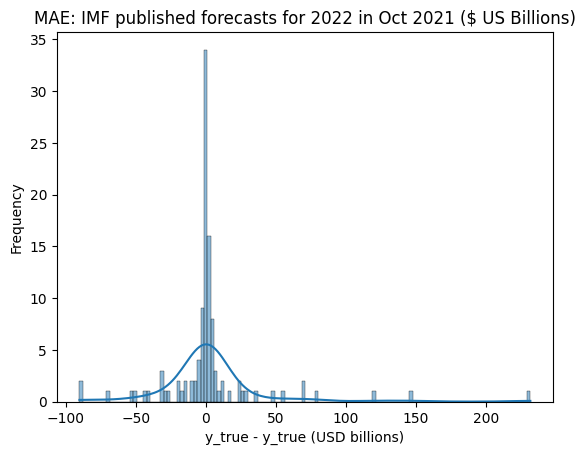

In [ ]:
imf_forecast_results_df['error'] = imf_forecast_results_df['2022'] - imf_forecast_results_df['2022_forecast']
sns.histplot(imf_forecast_results_df['error'], kde=True)
plt.xlabel('y_true - y_true (USD billions)')
plt.ylabel('Frequency')
plt.title('MAE: IMF published forecasts for 2022 in Oct 2021 ($ US Billions)')
plt.show()

#### MAPE

In [ ]:
imf_mape = error_mape(imf_forecast_results_df['2022_forecast'],
                      imf_forecast_results_df['2022'])
print('IMF MAPE = ', imf_mape)

IMF MAPE =  0.10183044664004536


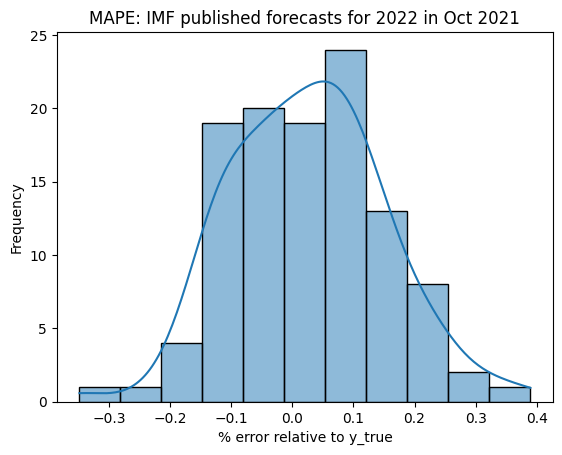

In [ ]:
imf_forecast_results_df['relative_error'] = (imf_forecast_results_df['2022'] -
                                             imf_forecast_results_df['2022_forecast'])/imf_forecast_results_df['2022']
sns.histplot(imf_forecast_results_df['relative_error'], kde=True)
plt.xlabel('% error relative to y_true')
plt.ylabel('Frequency')
plt.title('MAPE: IMF published forecasts for 2022 in Oct 2021')
plt.show()

## Visualizations

### Single country - before and after transformation

In [ ]:
country_of_choice = 'India'

#### Before

In [ ]:
# before
plot_cleaned_gdp_df = cleaned_gdp_df[cleaned_gdp_df['country'] == country_of_choice]
plot_cleaned_gdp_df

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,country
62,189.438,196.535,203.537,222.049,215.556,237.618,252.751,283.75,299.645,301.234,...,2671.596,3150.307,3389.689,3732.224,4105.381,4511.847,4951.615,5427.392,5944.382,India


In [ ]:
country_melted_df = pd.melt(plot_cleaned_gdp_df, id_vars=['country'], var_name='year', value_name='gdp')
country_melted_df.head()

,country,year,gdp
0,India,1980,189.438
1,India,1981,196.535
2,India,1982,203.537
3,India,1983,222.049
4,India,1984,215.556


AttributeError: ignored

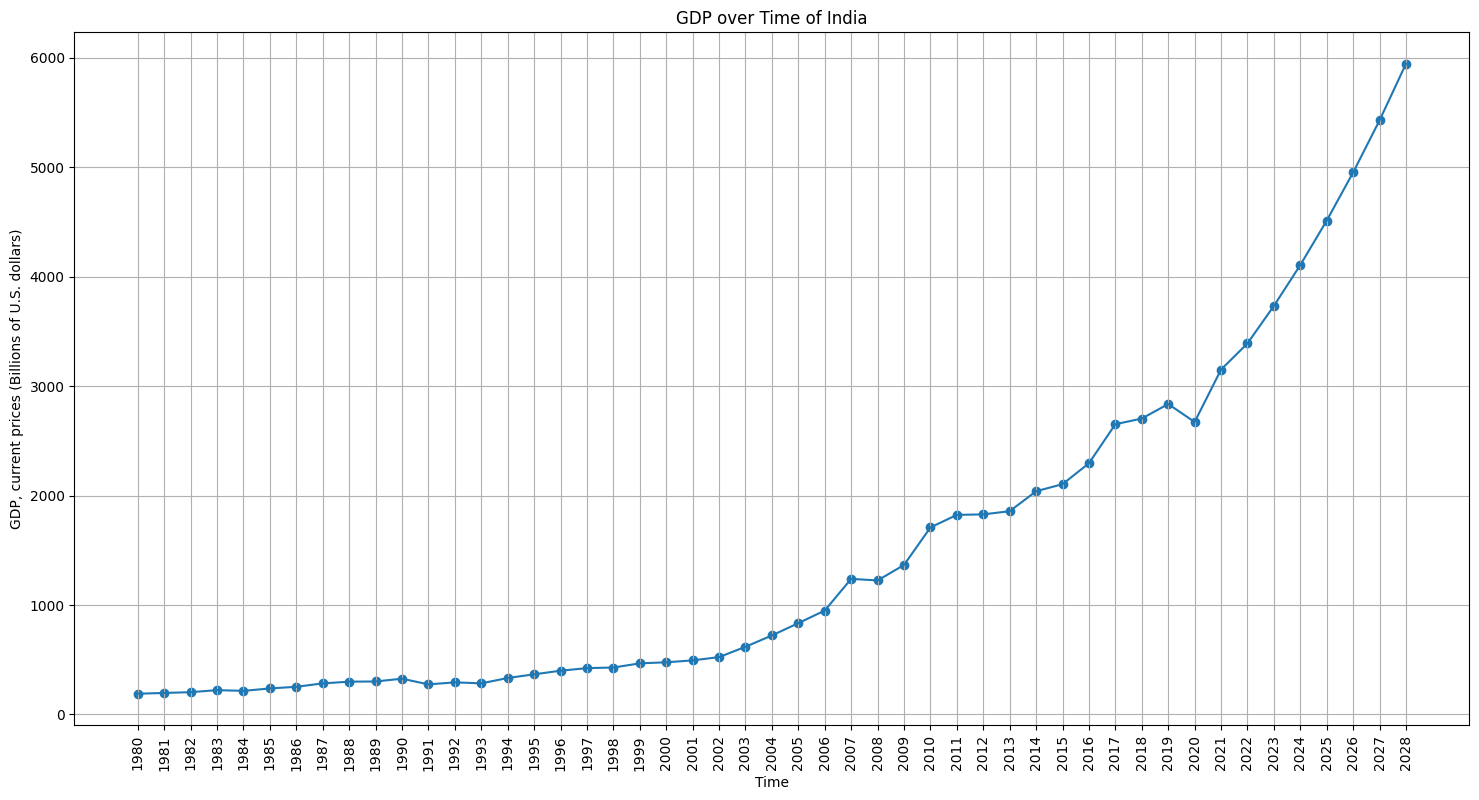

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(country_melted_df['year'], country_melted_df['gdp'])
plt.scatter(country_melted_df['year'], country_melted_df['gdp'])
plt.title(f'GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP, current prices (Billions of U.S. dollars)')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.figsave('gdpraw.png')

<Figure size 3600x1200 with 0 Axes>

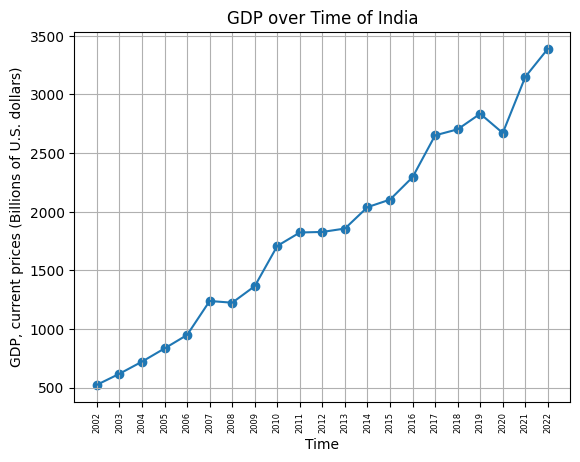

<Figure size 3600x1200 with 0 Axes>

In [ ]:
temp = country_melted_df[country_melted_df['year'].astype(int) >= 2002]
temp = temp[temp['year'].astype(int) <= 2022]

plt.plot(temp['year'], temp['gdp'])
plt.scatter(temp['year'], temp['gdp'])
plt.title(f'GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP, current prices (Billions of U.S. dollars)')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(fontsize=6)
plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.figure(figsize=(36, 12))

#### After

In [ ]:
# before
transformed_gdp_df = transformed_gdp_df[cleaned_gdp_df['country'] == country_of_choice]
transformed_gdp_df

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,country
62,6.78,6.79,6.82,6.87,6.93,7.03,6.95,7.08,7.17,7.13,...,7.18,7.24,7.29,7.36,7.33,7.38,7.35,7.35,7.39,India


In [ ]:
transformed_country_melted_df = pd.melt(transformed_gdp_df, id_vars=['country'], var_name='year', value_name='gdp')
transformed_country_melted_df.head()

,country,year,gdp
0,India,2002,6.78
1,India,2003,6.79
2,India,2004,6.82
3,India,2005,6.87
4,India,2006,6.93


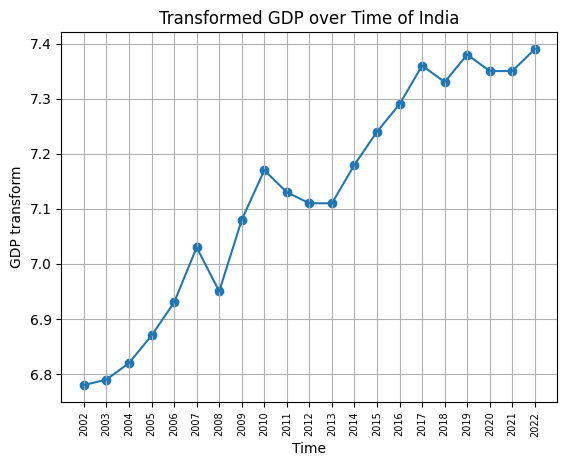

In [ ]:
plt.plot(transformed_country_melted_df['year'], transformed_country_melted_df['gdp'])
plt.scatter(transformed_country_melted_df['year'], transformed_country_melted_df['gdp'])
plt.title(f'Transformed GDP over Time of {country_of_choice}')
plt.xlabel('Time')
plt.ylabel('GDP transform')

# # Set the x-axis ticks to show every tenth value
# x_ = list(country_melted_df[['year']])
# x_ticks = x_[::2]
# print(x_ticks)
# plt.xticks(x_ticks)

plt.xticks(fontsize=7)
plt.xticks(rotation=90)

# show a grid
plt.grid(True)
plt.show()

In [ ]:
cleaned_gdp_df.tail()

,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
167,Middle East and Central Asia,527.714,588.285,581.559,591.099,599.786,617.744,626.892,743.168,780.507,...,3820.148,3412.564,3995.072,4750.874,4698.168,4893.834,5168.551,5442.165,5743.487,6066.951
168,Other advanced economies,775.274,790.860,785.664,784.097,821.924,819.463,999.432,1230.294,1450.500,...,7451.982,7404.808,8568.574,8581.514,8800.731,9147.297,9605.214,10061.637,10511.283,10975.395
169,Sub-Saharan Africa,317.456,335.793,338.583,311.806,247.335,225.926,257.466,279.882,301.615,...,1768.224,1672.529,1886.949,2013.032,1957.231,2084.818,2271.584,2458.237,2654.768,2875.895
170,World,11232.069,11526.241,11310.303,11610.283,12025.117,12553.732,14793.158,17032.786,19156.083,...,87325.540,84960.903,96487.666,100135.361,104476.432,109734.270,115598.839,121580.994,127499.667,133782.888
171,"©IMF, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
